In [1]:
import pandas as pd
import code_base as cb
import matplotlib.pyplot as plt
import numpy as np

import statsmodels as sm


end


# **Group Project** 


## **Introduction** 
- we see the effect of value and momentum factors having postitive effects when combined together
- on their is also wide documentation of "earning announcement effect", where abnormal returns have been found from earning announcements from holding before and after announcement periods 

- this is from,
- rather than the indiviudal day holding we would like to investimage if this would also affect the a stock's factor exposure, 
- we would like to investigate if this would substaintially affect the 

### Creating Factors

In [2]:
# extracting data
df_dict = cb.read_multi_csv(
    filenames=["df_memboolG_spx","df_mcap_spx","df_monthly_spx","df_annsup_spx","df_annest_spx","df_anndat_spx","df_annacc_spx","df_P2BR_spx","df_Beta_spx"],
    name = ["tmbool", "mcap", "price", "annsup", "annest", "anndat", "annacc", "ptbr", "beta"]
)

In [3]:

# shifting regieme by 1 to prevent hindsight bias  
df_dict["annacc"]=df_dict["annacc"].shift(1)
df_dict["annsup"]=df_dict["annsup"].shift(1)

# creating value factor
df_dict["VAL"] = 1/df_dict["ptbr"]

# creating a earnings suprise factor
df_dict["SUP"] =  df_dict["anndat"].shift(1)*df_dict["annsup"]
# df_dict["SUP"].ffill(inplace=True)

# creating stock returns 
df_dict["ret"] = (df_dict["price"]/df_dict["price"].shift(1))-1



In [4]:
# calculating momentum factor, the returns from -2 to -12
tdf = pd.DataFrame(df_dict["ret"])
tdf +=1 
tdf = tdf.rolling(11,11).apply(np.prod, raw=True)

df_dict["MOM"] = tdf.shift(1)
df_dict["MOM"] -=1

df_dict["avgret"] = tdf.rolling(12,12).apply(np.mean, raw=True)
df_dict["ABR"] = tdf.div(df_dict["avgret"])

# # absolute momentum (where we take mean of 0 when calculating, )
df_dict["MOM-A"] = df_dict["MOM"].copy()
# # df_dict["MOM-A"] = df_dict["MOM-A"].divide(df_dict["MOM-A"].std(1,skipna=True), "index")

# size factor
df_dict["CAP"] = df_dict["mcap"]

# earning estimates (EST), actual earnings (ERN)
df_dict["EST"] = df_dict["annest"]

df_dict["EP4"] = cb.past_nvalid_values(df_dict["annest"],4)
ans = (df_dict["annest"].ffill().divide(df_dict["EP4"])-1)
ans[ans<-100]=-100
ans[ans>2000]=2000
df_dict["ETG"] = ans
df_dict["ETG"].ffill(inplace=True)


# df_dict["ERN"] = df_dict["annacc"]

# earnings growth factor 
df_dict["AP4"] = cb.past_nvalid_values(df_dict["annacc"],4)
ans = (df_dict["annacc"].divide(df_dict["AP4"])-1)
ans[ans<-100]=-100
ans[ans>2000]=2000
df_dict["ERG"] = ans
df_dict["ERG"].ffill(inplace=True)

ans1 = ans.ffill()
df_dict["ARG"] = ans.ffill().rolling(12,12).mean(skipna=True)

df_dict["DIF"] = df_dict["ARG"]+df_dict["ERG"]
out_dict = cb.dict_transfer(df_dict,["ret","VAL","MOM","MOM-A","SUP","ERG","CAP","EST","ETG","ARG","DIF","ABR"])



In [5]:
# generate a "test" set & "training" set
tmbool =  df_dict["tmbool"].copy()
# ratio = 60%
ratio = 0.6
row = int(round((tmbool.shape[0])*ratio,0))
tmbool_train = tmbool.iloc[12:row,:]
tmbool_test = tmbool.iloc[row:,:]

In [6]:


# df_dict["ERG"] = df_dict["ERG"].divide(df_dict["ERG"].std(1,skipna=True), "index")
# apply normalisation

# out_dict = cb.dict_transfer(df_dict,["ret","VAL","MOM","MOM-A","SUP","ERG","CAP","EST","ETG","ARG","DIF","ABR"])


data = cb.data_obj(tmbool,out_dict)

data.calc_z_scores(True,["MOM","VAL"],clip="True")
data.calc_z_scores(True,["MOM-A","ERG","ETG","ABR"],False,clip="True")



### Momentum and Value Portfolio
- Effects of the Momentum and Value Portfolio

-1.6625879874177434
-0.273993899538573


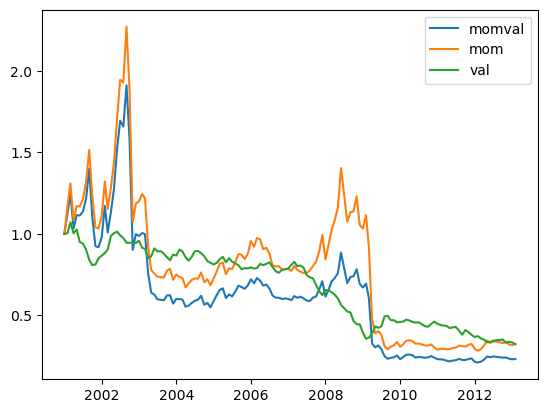

In [7]:
# calculate momentum value composite factor  
momval = (data.get("VAL").fillna(0)+data.get("MOM").fillna(0))/2
data.append("MOM_VAL", momval)
# data.regulate(["MOM_VAL"])
data.calc_z_scores(inplace=True,fields=["MOM_VAL"])
port_momval = data.to_port("MOM_VAL",tmbool=tmbool_train)


port_momval.gen_weights_from_score(0.1)
momval_ret, momval_cret = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)

port_mom = data.to_port("MOM",tmbool=tmbool_train)
port_mom.gen_weights_from_score(0.1)
mom_ret, mom_cret = port_mom.get_port_ret(weight=port_mom.lsw,bps=10)

port_val = data.to_port("VAL",tmbool=tmbool_train)
port_val.gen_weights_from_score(0.1)
mom_ret, val_cret = port_val.get_port_ret(weight=port_val.lsw,bps=10)

plt.plot(momval_cret)
plt.plot(mom_cret)
plt.plot(val_cret)

plt.legend(["momval","mom","val"])
print(cb.infomation_ratio(momval_cret,mom_cret))
print(cb.infomation_ratio(momval_cret,val_cret))

1.4951030270117607
1.393816773184581


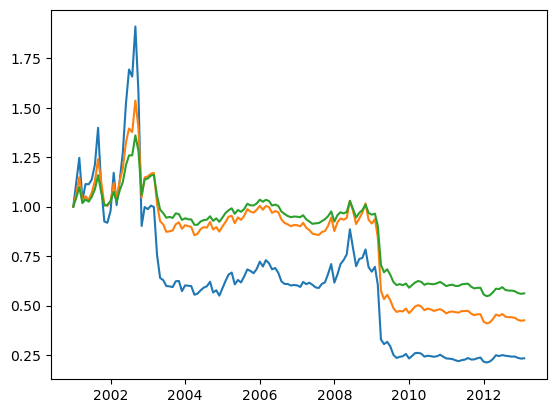

In [8]:
port_momval.gen_weights_from_score(0.1)
_, momval_tcret = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)

port_momval.gen_weights_from_score(0.3)
_, momval_tcret2 = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)

port_momval.gen_weights_from_score(0.5)
_, momval_tcret3 = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)

plt.plot(momval_tcret)
plt.plot(momval_tcret2)
plt.plot(momval_tcret3)

print(cb.infomation_ratio(momval_tcret2,momval_tcret))
print(cb.infomation_ratio(momval_tcret3,momval_tcret))


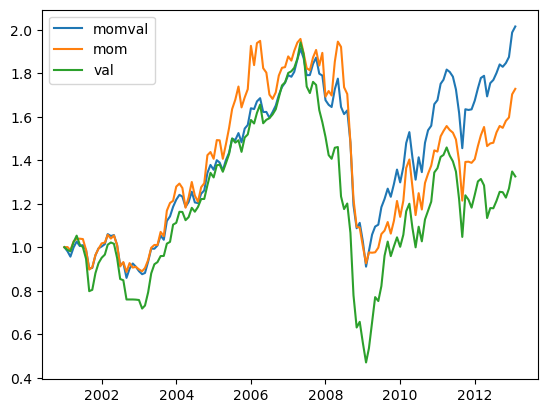

In [9]:

_, momval_tcret = port_momval.get_port_ret(weight=port_momval.lw,bps=10)
_, mom_tcret = port_mom.get_port_ret(weight=port_mom.lw,bps=10)
_, val_tcret = port_val.get_port_ret(weight=port_val.lw,bps=10)

plt.plot(momval_tcret)
plt.plot(mom_tcret)
plt.plot(val_tcret)

plt.legend(["momval","mom","val"])




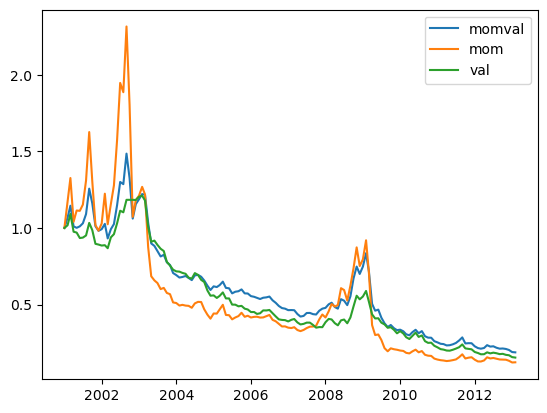

In [10]:

_, momval_tcret = port_momval.get_port_ret(weight=port_momval.sw,bps=10)
_, mom_tcret = port_mom.get_port_ret(weight=port_mom.sw,bps=10)
_, val_tcret = port_val.get_port_ret(weight=port_val.sw,bps=10)

plt.plot(momval_tcret)
plt.plot(mom_tcret)
plt.plot(val_tcret)

plt.legend(["momval","mom","val"])

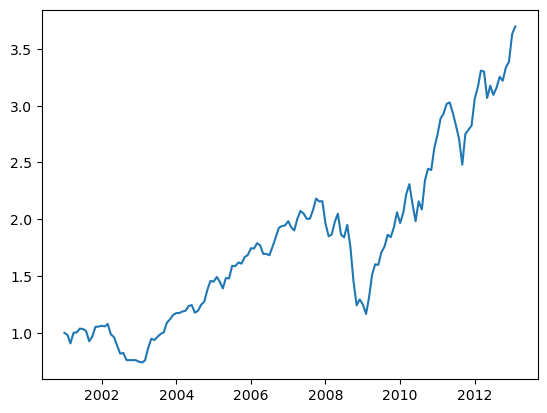

In [11]:

_, val_tcret = port_val.get_port_ret(weight=-port_val.sw,bps=10)
plt.plot(val_tcret)

### Investigated Factors

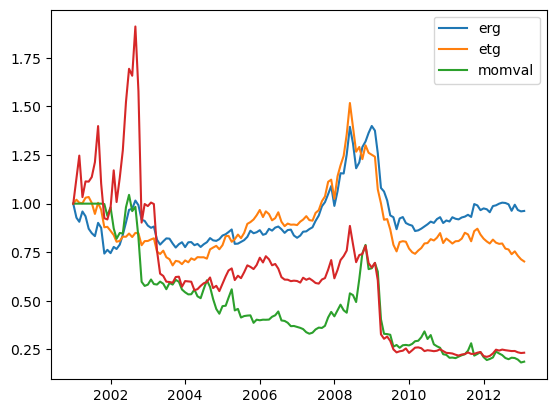

In [12]:
port_erg = data.to_port("ERG",tmbool=tmbool_train)
port_erg.gen_weights_from_score(0.1)
_, erg_cret = port_erg.get_port_ret(weight=port_erg.lsw,bps=10)
plt.plot(erg_cret)

port_etg = data.to_port("ETG",tmbool=tmbool_train)
port_etg.gen_weights_from_score(0.1)
_, etg_cret = port_etg.get_port_ret(weight=port_etg.lsw,bps=10)
plt.plot(etg_cret)

port_etg = data.to_port("ABR",tmbool=tmbool_train)
port_etg.gen_weights_from_score(0.1)
_, etg_cret = port_etg.get_port_ret(weight=port_etg.lsw,bps=10)
plt.plot(etg_cret)

# port_sup = data.to_port("SUP",tmbool=tmbool_train)
# port_sup.gen_weights_from_score(0.1)
# _, sup_cret = port_sup.get_port_ret(weight=port_sup.lsw,bps=10)
# plt.plot(sup_cret)

plt.plot(momval_cret)
# plt.plot(mom_cret)
# plt.plot(val_cret)

plt.legend(["erg","etg","momval"])

0.8405537376719369

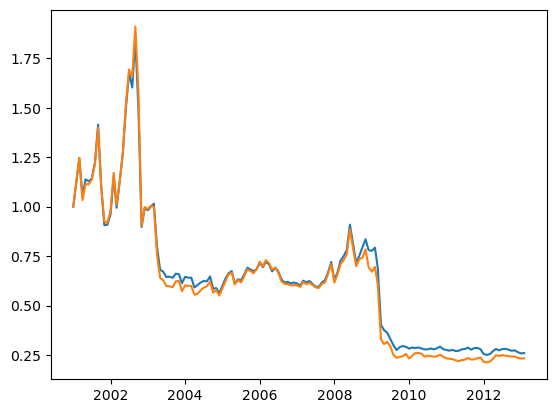

In [13]:
# calculate momentum value composite factor  
composite = (+0.1*data.get("VAL").fillna(0)
             +0.1*data.get("MOM").fillna(0)
             +0.8*data.get("ERG").fillna(0))
data.append("COM", composite)

data.calc_z_scores(inplace=True,fields=["COM"])
port_com = data.to_port("COM",tmbool=tmbool_train)
port_com.gen_weights_from_score(0.1)
_, com_cret = port_com.get_port_ret(weight=port_com.lsw,bps=10)

plt.plot(com_cret)
plt.plot(momval_cret)

cb.infomation_ratio(com_cret,momval_cret)

### Method 1) Spliting Weights

2.1968461870382825

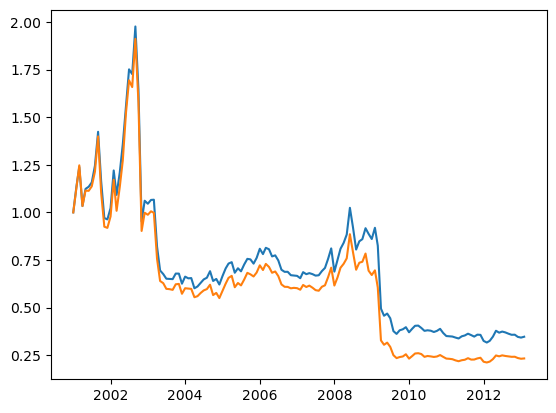

In [14]:
try: 
    data.data_dict.pop("EJC")
except:
    pass 

sup = data.get("SUP")
mom = data.get("MOM")
val = data.get("VAL")

mom.fillna(0,inplace = True)
val.fillna(0,inplace = True)
cuttoff = 0.5

fmb = 0.6
fvb = 0.4
fcb = 0.1

fmp = 0.75
fvp = 0.25
fcp = 1

fmn = 0.825
fvn = 0.125
fcn = -1.75

# basecase 

ejustc = fmb*mom + fvb*val + fcb

# positive
ejustc[sup>=cuttoff] = fmp*mom[sup>=cuttoff] + fvp*val[sup>=cuttoff] + fcp

# neg
# cuttoff = 0.5

ejustc[sup<= -cuttoff] = fmn*mom[sup<= -cuttoff] + fvn*val[sup<= -cuttoff] + fcn

data.append("EJC",ejustc)



port_ejc = data.to_port("EJC", tmbool_train)
port_ejc.gen_weights_from_score(0.1)
ejc_ret, ejc_cret= port_ejc.get_port_ret( port_ejc.lsw, bps=10)

# lejc_ret, lejc_cret= port_ejc.get_port_ret(port_ejc.sw,bps=10)

plt.plot(ejc_cret)
plt.plot(momval_cret)
# plt.plot(mom_cret)
# plt.plot(lejc_cret)
cb.infomation_ratio(ejc_cret,momval_cret)

### Primary vs Secondary Effects

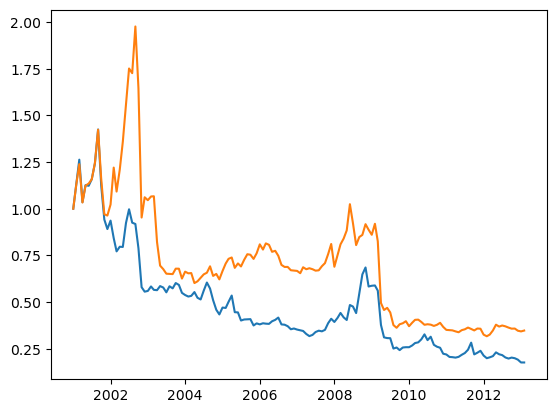

In [15]:
try: 
    data.data_dict.pop("EJC2")
except:
    pass 

sup = data.get("ABR").copy()
mom = data.get("MOM").copy()
val = data.get("VAL").copy()
abr = data.get("ABR").copy()

mom.fillna(0,inplace = True)
val.fillna(0,inplace = True)
cuttoff = 0.4

fmb = 0.6
fvb = 0.4
fcb = 0.1

fmp = 1
fvp = 0
fcp = 0.5

fmn = 0 # 0.09
fvn = -1 # 0.91
fcn = -1 # -1

# basecase 
ejustc2 = fmb*mom + fvb*val + fcb

# positive
ejustc2[sup>=cuttoff] = fmp*(abr[sup>=cuttoff]) + fvp*val[sup>=cuttoff] + fcp

# neg
cuttoff = 0.6

ejustc2[sup<= -cuttoff] = fmn*abr[sup<= -cuttoff] + fvn*val[sup<= -cuttoff] + fcn

data.append("EJC2",ejustc2)

port_ejc2 = data.to_port("EJC2", tmbool_train)
port_ejc2.gen_weights_from_score(0.1)
ejc_ret2, ejc_cret2= port_ejc2.get_port_ret(port_ejc2.lsw,bps=10)

# lejc_ret, lejc_cret= port_ejc.get_port_ret(port_ejc.sw,bps=10)

plt.plot(ejc_cret2)
plt.plot(ejc_cret)
# plt.plot(mom_cret)


In [16]:
sup = data.get("SUP").copy()
ret = data.get("ret").copy().shift(-1)
data.append("RET-ML",ret)

cuttoff=0.5
tmb = tmbool_train.copy()
tmb[sup<cuttoff] = False

sup = pd.DataFrame(sup)


In [17]:



ans = data.gen_mldf(["MOM","VAL","RET-ML"],tmb)

In [18]:
ans.dropna()

MOM       VAL    RET-ML
Dates                                                      
2000-01-01 0111145D UN Equity  0.000000  0.000000 -0.113139
           0202445Q UN Equity  0.000000  0.000000  0.248176
           0203524D UN Equity  0.000000  0.000000  0.430952
           0226226D UN Equity  0.000000  0.000000 -0.105118
           0544749D UN Equity  0.000000  0.000000 -0.191872
...                                 ...       ...       ...
2021-09-01 TSLA UW Equity      0.470573 -0.748589  0.436530
           TYL UN Equity       0.054152 -0.547794  0.184389
           VNT UN Equity      -0.230010 -0.627394  0.006845
           VTRS UW Equity     -0.454193  2.549136 -0.014765
           WST UN Equity       0.381790 -0.661115  0.012578

[177038 rows x 3 columns]

In [19]:
ans.dropna()


MOM       VAL    RET-ML
Dates                                                      
2000-01-01 0111145D UN Equity  0.000000  0.000000 -0.113139
           0202445Q UN Equity  0.000000  0.000000  0.248176
           0203524D UN Equity  0.000000  0.000000  0.430952
           0226226D UN Equity  0.000000  0.000000 -0.105118
           0544749D UN Equity  0.000000  0.000000 -0.191872
...                                 ...       ...       ...
2021-09-01 TSLA UW Equity      0.470573 -0.748589  0.436530
           TYL UN Equity       0.054152 -0.547794  0.184389
           VNT UN Equity      -0.230010 -0.627394  0.006845
           VTRS UW Equity     -0.454193  2.549136 -0.014765
           WST UN Equity       0.381790 -0.661115  0.012578

[177038 rows x 3 columns]